In [21]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numba as nb
import cv2

In [3]:
# Set up environment
env = gym.make('CarRacing-v2', continuous=False)
# Then we reset this environment
# observation = env.reset()


print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


(96, 96, 3)


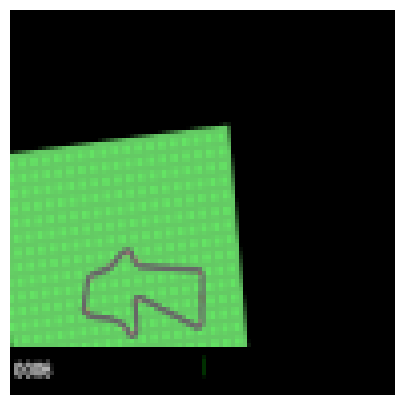

In [11]:
s, info = env.reset()
print(s.shape)

plt.figure(figsize=(5, 5))
plt.imshow(s)
plt.axis('off')
plt.show()

In [22]:
def crop(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping
    # img = cv2.resize(img, dsize=(84, 84)) # or you can simply use rescaling
    
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

In [23]:
@nb.njit(fastmath=True)
def rgb_to_grey(img):
    """
    Convert an RGB image to greyscale using the weighted method.
    """
    num_rows, num_cols, _ = img.shape
    grey_img = np.empty((num_rows, num_cols), dtype=np.uint8)
    for i, row in enumerate(img):
        for j, rgb_pixel in enumerate(row):
            # Compute weighted sum of RGB channels
            grey_img[i, j] = 0.2989 * rgb_pixel[0] + 0.5870 * rgb_pixel[1] + 0.1140 * rgb_pixel[2]

    return grey_img

In [39]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        # colours = np.array([[170,0,0],[105,230,105],[0,0,0],[101,101,101],[255,255,255]]),
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
        # self.colours = colours

    
    def reset(self):
        # reset the original environment
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # crop image
        s = crop(s)
        s = rgb_to_grey(s)
        

        # initial observation is simply a copy of the frame 's'
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))
        return self.stacked_state, info
    
    def step(self, action):
        # Take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        s = crop(s)
        s = rgb_to_grey(s)

        # push the current frame 's' at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info
    

The shape of an observation:  (4, 84, 84)


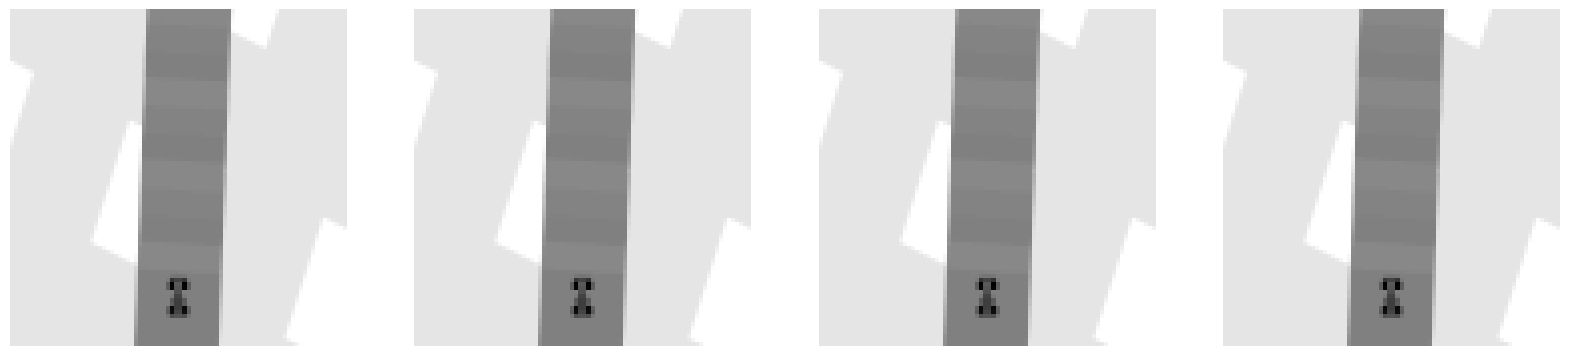

In [40]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

## Creating Q network

In [43]:
class CNNActionValue(tf.keras.Model):
    def __init__(self, state_dim, action_dim, activation=tf.nn.relu):
        super(CNNActionValue, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, kernel_size=8, strides=4, input_shape=state_dim) # [N, 4, 84, 84] -> [N, 16, 20, 20]
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=4, strides=2) # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(256, activation=activation)
        self.fc2 = tf.keras.layers.Dense(action_dim)

    def call(self, x):
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

From paper: "The input to the neural network consists is an 84 × 84 × 4 image produced by 
. The first hidden layer convolves 16 8 × 8 filters with stride 4 with the input image and applies a rectifier nonlinearity [10, 18]. The second hidden layer convolves 32 4 × 4 filters with stride 2, again followed by a rectifier nonlinearity. The final hidden layer is fully-connected and consists of 256 rectifier units. The output layer is a fullyconnected linear layer with a single output for each valid action"

## Replay buffer

Replay buffer used to store transitions experienced by the agent during its interaction with the environment.

In a DQN, the agent learns by updating its Q-network weights using a batch of experiences collected from its replay buffer, rather than using each experience only once and discarding it. The replay buffer stores a large number of these experiences in a first-in, first-out (FIFO) queue, allowing the agent to learn from them multiple times.

Each experience is a tuple of four elements: the current state, the action taken in that state, the reward obtained from that action, and the resulting next state. These experiences are collected during the agent's interaction with the environment and stored in the replay buffer.

During training, the agent samples a mini-batch of experiences from the replay buffer at random and uses them to update its Q-network. This process of randomly sampling and reusing past experiences helps to break the correlation between consecutive updates and stabilizes the learning process.

Replay buffers have been shown to be effective in improving the stability and convergence of DQN training, and are commonly used in deep reinforcement learning algorithms.

In [45]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            tf.constant(self.s[ind], dtype=tf.float32),
            tf.constant(self.a[ind], dtype=tf.int32),
            tf.constant(self.r[ind], dtype=tf.float32),
            tf.constant(self.s_prime[ind], dtype=tf.float32),
            tf.constant(self.terminated[ind], dtype=tf.float32),
        )

## DQN

In [59]:
class DQN(tf.keras.Model):
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.00025,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=32,
        warmup_steps=5000,
        buffer_size=int(1e5),
        target_update_interval=10000,
    ):
        super(DQN, self).__init__()

        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.network = CNNActionValue(state_dim[0], action_dim)
        self.target_network = CNNActionValue(state_dim[0], action_dim)
        self.target_network.set_weights(self.network.get_weights())
        self.optimizer = tf.keras.optimizers.RMSprop(lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)

        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6

    @tf.function
    def act(self, x, training=True):
        if training and ((tf.random.uniform([]) < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = tf.random.uniform([], maxval=self.action_dim, dtype=tf.int64)
        else:
            x = tf.expand_dims(x, axis=0)
            q = self.network(x)
            a = tf.argmax(q, axis=-1)
        return a.numpy()[0]

    @tf.function
    def learn(self):
        s, a, r, s_prime, terminated = self.buffer.sample(self.batch_size)
        s = tf.convert_to_tensor(s)
        a = tf.convert_to_tensor(a)
        r = tf.convert_to_tensor(r)
        s_prime = tf.convert_to_tensor(s_prime)
        terminated = tf.convert_to_tensor(terminated)

        with tf.GradientTape() as tape:
            next_q = self.target_network(s_prime)
            td_target = r + (1. - terminated) * self.gamma * tf.reduce_max(next_q, axis=-1, keepdims=True)
            q_values = tf.gather_nd(self.network(s), tf.stack((tf.range(a.shape[0]), a[:, 0]), axis=1))
            loss = tf.reduce_mean(tf.square(q_values - tf.stop_gradient(td_target)))

        gradients = tape.gradient(loss, self.network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))

        result = {
            'total_steps': self.total_steps,
            'value_loss': loss.numpy(),
        }
        return result

    def process(self, transition):
        result = {}
        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            result = self.learn()

        if self.total_steps % self.target_update_interval == 0:
            self.target_network.set_weights(self.network.get_weights())
        self.epsilon -= self.epsilon_decay
        return result


## Training DQN Agent

We will train DQN agent until the total number of interactions with the environment reaches 2 millilons and evaluate our agent evry 10,000 steps

In [60]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = int(2e6)
eval_interval = 10000
state_dim = (84, 84, 4)  
action_dim = env.action_space.n

agent = DQN(state_dim, action_dim)

TypeError: 'int' object is not iterable